## Topic Modelling(Text Analytics)

* Whether the reviews are talking about the product or platform ?
* Top 5 features about the PRODUCT that the customers are talking about(across brands).
* Sentiments attached with the features to be combined into "Others"
* If we can measure the regression coefficients or correlation between the pos/neg sentiments about a feature and the rating for the product

In [144]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import re
import numpy as np
import pandas as pd
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
# warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# Visualizaing pyLDA model
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

In [ ]:
data = pd.read_excel("Hanger Reviews consolidated.xlsx") # read data

In [5]:
print(data.shape)
data[["Product","Review", "Rating"]].head()

(4077, 17)


,Product,Review,Rating
0,3M Command Picture Hanging,This is a review of the Command Picture Hangin...,5
1,3M Command Picture Hanging,Cleaned area with alcohol and followed steps e...,1
2,3M Command Picture Hanging,Update: Feb 2018. It has been a little over a ...,4
3,3M Command Picture Hanging,"Do not buy this from Amazon. Go to your local,...",1
4,3M Command Picture Hanging,I have found about a million uses for these th...,5


In [6]:
data['Product'].value_counts()

3M Command Picture Hanging    2331
VELCRO                         744
Hangman Products               435
Beehive Picture Hangers        266
GoodHangups                    191
eBoot                          110
Name: Product, dtype: int64

In [7]:
#sample review
data.Review[10]

"Fabulous....a bit difficult to get up, initially. You *need* to level your frame at the bottom then angle it up to place the tabs, and they're serious about letting those tabs sit for at least an hour before you hang the heavier pictures (learn from my fail). If you follow the instructions, they work *brilliantly*"

In [8]:
# Helper Functions
# Preprocessing
from nltk.corpus import stopwords
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Define functions for lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(sent) 
        texts_out.extend([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    return " ".join(texts_out)

nlp = spacy.load('en', disable=['parser', 'ner'])

In [112]:
# Remove punctuation
data['Review_processed'] = data['Review'].apply(lambda x: re.sub(r'[\W\s]', ' ', x.lower()))

In [113]:
# Remove Stopwords and numbers
data['Review_processed'] = data['Review_processed'].str.replace(r'\d+', '')
data['Review_processed'] = data['Review_processed'].apply(lambda x: [item for item in x.split() if item not in stop_words])

In [114]:
# lemmatization
data['Review_processed'] = data['Review_processed'].apply(lemmatization)

In [115]:
data['Review_processed'][0]

'review command picture hang strip value pack large white strip get total individual strip box strip minimum need hang object summary daughter part local roller skate club lucky oversee plaque wall rink permit nail wall find way mount item damage wall serve perfect solution note description truly offer damage free hang item tab end lift nee remove strip surface constantly move item around let ease speed leave damage strip measure long wide exclude tab remove strip rate hold lb use set item give ability hold lb use set would hold lb hold light weight frame heavy wood plaque ease tip clean surface use good result instal press hold approx second remove item wall twist pull item try pull straight review develop issue ongoing update review accordingly'

In [13]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [151]:
# Initialise the count vectorizer
count_vectorizer = CountVectorizer(min_df=10, max_df=800)
# count_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01)

In [152]:
# Fit and transform the processed Review
count_data = count_vectorizer.fit_transform(data.Review_processed)

In [153]:
count_data

<4077x792 sparse matrix of type '<class 'numpy.int64'>'
	with 44571 stored elements in Compressed Sparse Row format>

In [154]:
# plot function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts)) # dict
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10] # sort dict
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/2))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

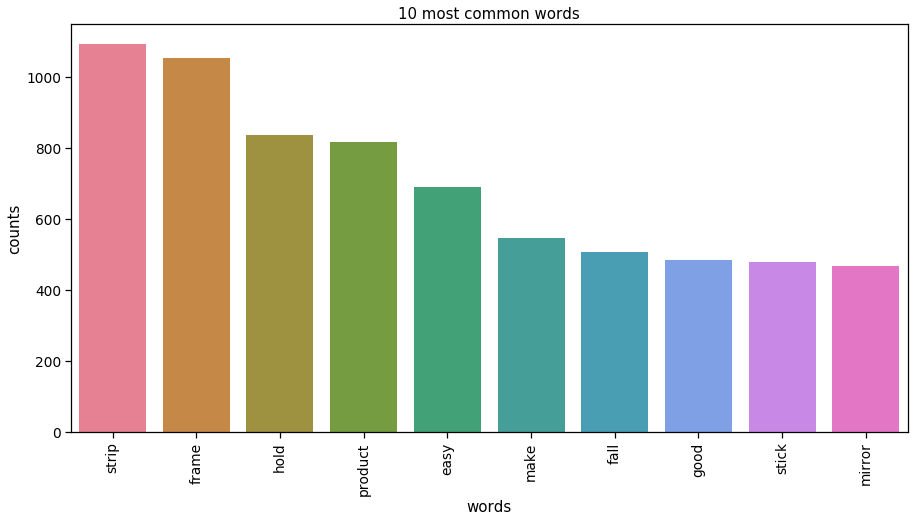

In [155]:
plot_10_most_common_words(count_data, count_vectorizer) # Exclude high frequency word > 1000

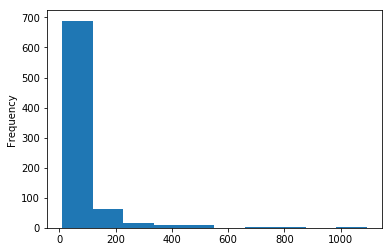

In [116]:
vec_data = pd.DataFrame({"Frequency":pd.Series(count_data.toarray().sum(axis=0)),"words":count_vectorizer.get_feature_names()}).sort_values(by='Frequency')
vec_data['Frequency'].plot(kind='hist')

In [117]:
vec_data

,Frequency,words
283,10,frustration
347,10,important
461,10,numerous
460,10,number
256,10,fear
705,10,teacher
447,10,nervous
704,10,task
222,10,error
78,10,block


In [106]:
# Set parameters
num_topics = 6
batch_size = 500 
passes = 20 
iterations = 400
eval_every = 1  

In [107]:
# Create and fit the LDA model
lda = LDA(n_components = num_topics, 
          batch_size = batch_size, 
          max_iter = iterations,
          evaluate_every = eval_every,
         random_state = 101)
lda.fit(count_data)

LatentDirichletAllocation(batch_size=500, doc_topic_prior=None,
             evaluate_every=1, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=400,
             mean_change_tol=0.001, n_components=6, n_jobs=None,
             n_topics=None, perp_tol=0.1, random_state=101,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [108]:
# Function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(",".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [109]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
frame,fall,break,weight,buy,strip,follow,hold,money,waste

Topic #1:
strip,command,paint,remove,try,back,damage,product,stick,would

Topic #2:
product,good,board,hold,strip,purchase,command,job,price,quality

Topic #3:
mirror,easy,heavy,item,need,large,hold,mount,install,level

Topic #4:
hold,velcro,stick,poster,strong,love,thing,heavy,side,light

Topic #5:
frame,hanger,easy,make,hole,nail,screw,want,get,love


In [ ]:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

In [111]:
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')

## **************************************************************************************************** 

*__Extract Features__*

In [136]:
def pos_tagged(sents, pos_tag=['ADJ']):
    """https://spacy.io/usage/linguistic-features#pos-tagging"""
    texts_out = []
    doc = nlp(sents) 
    texts_out.extend([token.lemma_ for token in doc if token.pos_ in pos_tag])
    return list(set(texts_out))

In [139]:
data['Features'] = data['Review'].apply(pos_tagged)

In [241]:
data[['Product - F1','Product - F2','Product - F3','Product - F4','Product - F5']] = pd.DataFrame(data['Features'].apply(lambda x: [y for y in x[:5]]).values.tolist(), index= data.index)

In [242]:
data[['Product - F1','Product - F2','Product - F3','Product - F4','Product - F5']] .tail()

,Product - F1,Product - F2,Product - F3,Product - F4,Product - F5
4072,standard,None,None,None,None
4073,dangerous,small,None,None,None
4074,strong,None,None,None,None
4075,flat,None,None,None,None
4076,dangerous,small,None,None,None


In [275]:
def pos_tag_noun(sents, pos_tag=['NOUN']):
    """https://spacy.io/usage/linguistic-features#pos-tagging"""
    texts_out = []
    doc = nlp(sents) 
    texts_out.extend([token.lemma_ for token in doc if token.pos_ in pos_tag])
    return list(set(texts_out))

In [317]:
data['Product.1'] = data['Review_processed'].apply(pos_tag_noun)

*__Features Sentiments__*

In [244]:
# Sentiments Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def polarity_score(sentence):
    try:
        score = analyser.polarity_scores(sentence)
        return score['compound']
    except:
        pass

In [205]:
polarity_score('worried') # output results {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.296}, taking only compound score

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.296}

In [247]:
data['Others - Sentiment'] = data['Review'].apply(polarity_score) # Review sentiments

In [245]:
# All feature sentiments
data['F1 - Sentiment'] = data['Product - F1'].apply(polarity_score)
data['F2 - Sentiment'] = data['Product - F2'].apply(polarity_score)
data['F3 - Sentiment'] = data['Product - F3'].apply(polarity_score)
data['F4 - Sentiment'] = data['Product - F4'].apply(polarity_score)
data['F5 - Sentiment'] = data['Product - F5'].apply(polarity_score)

In [318]:
data.to_excel('Hanger Reviews consolidated Solution.xlsx')

### GENSIM

In [326]:
from gensim import corpora

In [346]:
docs = data["Review_processed"].str.split(' ').values.tolist()

# Create Dictionary
dictionary = corpora.Dictionary(docs)

# dictionary.filter_extremes(no_below=1, no_above=1, keep_n=5000)
dictionary.filter_n_most_frequent(remove_n=1000)

# Create Corpus
corpus = [dictionary.doc2bow(text) for text in docs]

# print(dictionary.token2id)

In [347]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=5, 
                                           random_state=101,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [348]:
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.016*"flimsy" + 0.015*"honest" + 0.012*"odd" + 0.011*"faint" + '
  '0.010*"photographer" + 0.009*"cold" + 0.009*"tweak" + 0.009*"indentation" + '
  '0.009*"lifetime" + 0.009*"gadget"'),
 (1,
  '0.018*"magnasticker" + 0.015*"grid" + 0.015*"beautiful" + '
  '0.010*"screwdriver" + 0.010*"puncture" + 0.009*"question" + '
  '0.009*"dangerous" + 0.008*"lightly" + 0.007*"decently" + 0.007*"forget"'),
 (2,
  '0.016*"random" + 0.013*"goodhangup" + 0.011*"stainless" + 0.011*"showcase" '
  '+ 0.010*"mil" + 0.009*"cling" + 0.008*"wherever" + 0.008*"grandson" + '
  '0.008*"achieve" + 0.008*"envy"'),
 (3,
  '0.025*"hangup" + 0.017*"flexibility" + 0.012*"label" + 0.012*"thumb" + '
  '0.011*"eat" + 0.008*"forever" + 0.008*"uneasy" + 0.008*"mainly" + '
  '0.008*"dun" + 0.008*"starter"'),
 (4,
  '0.015*"refrigerator" + 0.014*"shark" + 0.012*"flatten" + 0.009*"theory" + '
  '0.008*"fun" + 0.008*"printer" + 0.007*"death" + 0.007*"map" + 0.007*"stare" '
  '+ 0.007*"consistently"')]


In [349]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [350]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [351]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.4342,"hangup, flexibility, label, thumb, eat, foreve...","[review, command, picture, hang, strip, value,..."
1,1,0.0,0.5686,"flimsy, honest, odd, faint, photographer, cold...","[clean, area, alcohol, follow, step, exactly, ..."
2,2,1.0,0.8770,"magnasticker, grid, beautiful, screwdriver, pu...","[update, feb, little, year, last, week, top, l..."
3,3,1.0,0.8166,"magnasticker, grid, beautiful, screwdriver, pu...","[buy, amazon, go, local, target, walmart, home..."
4,4,1.0,0.5181,"magnasticker, grid, beautiful, screwdriver, pu...","[find, use, thing, love, use, hang, small, con..."


In [352]:
print(df_dominant_topic.shape)
print(data.shape)

(4077, 5)
(4077, 19)


In [410]:
# df_dominant_topic.to_excel('Hanger Reviews consolidated Output.xlsx',index=False)

*__Try extracting Product and Platform name using ner model__*

In [279]:
import spacy
from spacy import displacy
nlp = spacy.load('en')
from spacy import displacy

In [283]:
doc = nlp(" ".join(count_vectorizer.get_feature_names())) 

In [291]:
# An example NER Model, that can be used to exract platform or product, not perform reason computationally heavy and time constraints
nlp = spacy.load("en")
doc = nlp(str(data['Review'][3]))
displacy.serve(doc, style="ent")

C:\Users\manish.singh04\AppData\Local\Continuum\anaconda3\lib\runpy.py:193: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  "__main__", mod_spec)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


# _End.._

## Summary:
* Extracted Nouns in Product.1 column, Using ner trained model on above data set can able to get proper noun/names of products
* Amazon and walmart are the popular platform in dataset
* Feature are the adjectives and there compund sentiment score
* Product - Others columns contains all relevant feature/adjectives
* Other- Sentiments is overall sentiments of review
* In this notebook topic modelling had also performed and generate html Visualization, to again an insight
* Results can be improved using specific dictionary and ner model with respect to business 

* References:
    * /nltk.org/
    * /spacy.io/
    * radimrehurek.com/gensim/